<a href="https://colab.research.google.com/github/marquesgabi/mineracao_trabalho_final/blob/main/Age_Estimation_Final_Test_gabi_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Idade

In [ ]:
import zipfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace with your path!
#!unzip -q /content/drive/MyDrive/TRY_ME/UTKFace.zip -d data
!unzip -q /content/drive/MyDrive/trabalho_final/UTKFace.zip -d data

In [ ]:
# !mv data/UTKFace data/UTKFace

In [ ]:
# para treino
!gdown 15dJJp8CJaaJ5JPoBgSlll_vCxy9vCdrV
df = pd.read_csv('train-utkface.csv')
df_train = df[['filename','age']]

# para val
!gdown 1l-DyeTfi5Q9tbZ9NgqGW0ABlr1X8kXqk
df = pd.read_csv('valid-utkface.csv')
df_val = df[['filename','age']]

# para test
!gdown 1c5W3OWc0fD8L3BAM9P5nNUlNGJHd8ZVv
df = pd.read_csv('test-utkface.csv')
df_test = df[['filename','age']]

# PATH_IMGS = '/sample_data'
PATH_IMGS = '/content/data'

Downloading...
From: https://drive.google.com/uc?id=15dJJp8CJaaJ5JPoBgSlll_vCxy9vCdrV
To: /content/train-utkface.csv
100% 740k/740k [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l-DyeTfi5Q9tbZ9NgqGW0ABlr1X8kXqk
To: /content/valid-utkface.csv
100% 185k/185k [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c5W3OWc0fD8L3BAM9P5nNUlNGJHd8ZVv
To: /content/test-utkface.csv
100% 231k/231k [00:00<00:00, 67.2MB/s]


In [ ]:
# PATH_IMGS contém o caminho para a pasta com as imagens
# image_size e target_size indicam o tamanho que a imagem será carregada, no exemplo, 128x128x3
# Para a regressão, o modelo tem class_mode igual a raw, já que usa os valores que estão na tabela
# A coluna age no dataframe tem a idade no formato inteiro
# Caso a memória estoure, vale a pena diminuir o batch_size

generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

train_generator = generator.flow_from_dataframe(
        df_train, directory=PATH_IMGS, x_col='filename', y_col=['age'], image_size=(128, 128),
        target_size=(128, 128), class_mode='raw', batch_size=16, shuffle=True)

val_generator = generator.flow_from_dataframe(
        df_val, directory=PATH_IMGS, x_col='filename', y_col=['age'], image_size=(128, 128),
        target_size=(128, 128), class_mode='raw', batch_size=16, shuffle=False)

test_generator = generator.flow_from_dataframe(
        df_test, directory=PATH_IMGS, x_col='filename', y_col=['age'], image_size=(128, 128),
        target_size=(128, 128), class_mode='raw', batch_size=16, shuffle=False)


# Exemplo com ResNet50V2
backbone = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(128,128,3), pooling='avg')

for layer in backbone.layers:
  layer.trainable = True

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Dense(1, activation=None)
])

model.compile(optimizer='adam', loss=['mae'])

history = model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=10)

Found 15170 validated image filenames.
Found 3793 validated image filenames.
Found 4742 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/50
949/949 [==============================] - 117s 84ms/step - loss: 9.9434 - val_loss: 10.3863
Epoch 2/50
949/949 [==============================] - 77s 81ms/step - loss: 8.0170 - val_loss: 7.9851
Epoch 3/50
949/949 [==============================] - 78s 82ms/step - loss: 7.2673 - val_loss: 8.9674
Epoch 4/50
949/949 [==============================] - 79s 83ms/step - loss: 6.7353 - val_loss: 7.4882
Epoch 5/50
949/949 [==============================] - 79s 84ms/step - loss: 6.2410 - val_loss: 6.7209
Epoch 6/50
949/949 [==============================] - 80s 84ms/step - loss: 5.8952 - val_loss: 6.4466
Epoch 7/50
949/949 [==============================] - 79s 83ms/step - loss: 5.5495 - val_loss: 6.1546
Epoch 8/50
949/949 [==============================] - 79s 84ms/step - loss: 5.3493 - val_loss: 6.0817
Epoch 9/50
949/949 [==============================] - 79s 83ms/step - loss: 5.0481 - val_loss: 6.0517
Epoch 10/50
949

In [ ]:
# Imprime a perda/MAE de treinamento e validação
print('Train MAE (Loss): ', history.history['loss'][-1])
print('Validation MAE (Loss): ', history.history['val_loss'][-1])

Train MAE (Loss):  1.3741323947906494
Validation MAE (Loss):  5.531011581420898


In [ ]:
# Avaliar o conjunto de teste
mae = model.evaluate(test_generator)
print('Test MAE: ', mae)

297/297 [==============================] - 7s 24ms/step - loss: 5.5661
Test MAE:  5.566066265106201


In [ ]:
# Adicionar mse
model.compile(optimizer='adam', loss='mae', metrics=['mse'])


In [ ]:
loss, mse = model.evaluate(test_generator)
print('Test loss (MAE): ', loss)
print('Test MSE: ', mse)


297/297 [==============================] - 9s 23ms/step - loss: 5.5661 - mse: 66.7429
Test loss (MAE):  5.566066265106201
Test MSE:  66.74292755126953


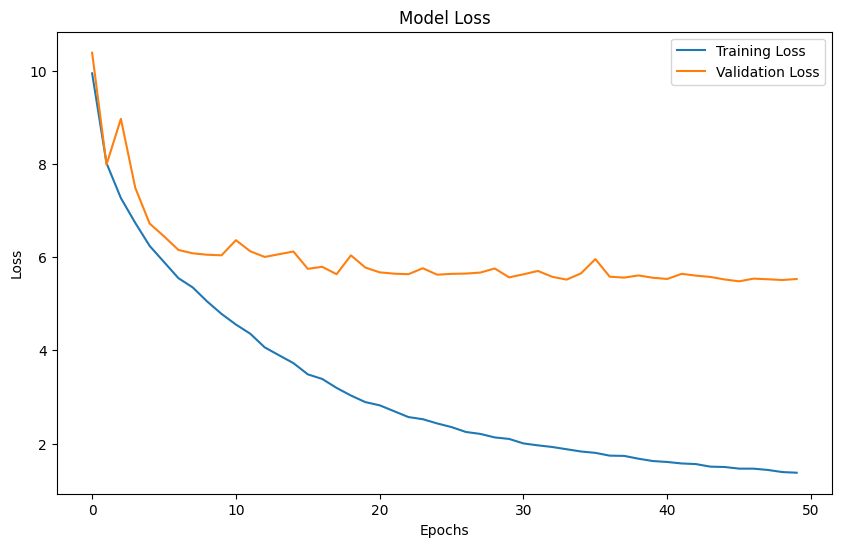

In [ ]:
# Plota o gráfico de perda
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
